# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [3]:

# np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 

#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


#### Régression linéaire avec régularisation Lasso ...


In [4]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


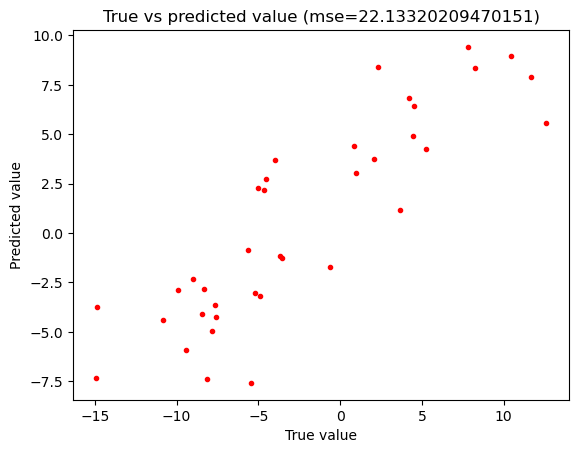

In [6]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()

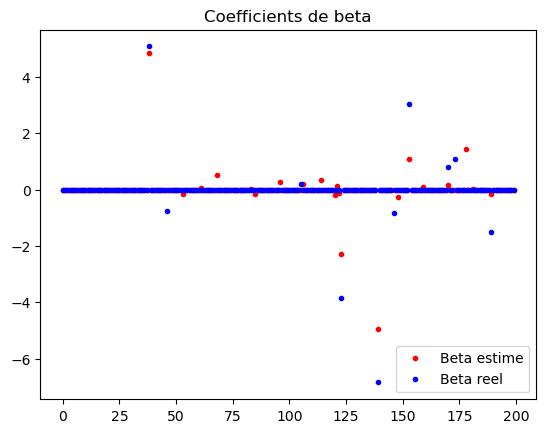

In [7]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

...



### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

In [8]:

from sklearn.model_selection import KFold

kf = KFold(n_splits=8, shuffle=True, random_state=42)
list_alpha = np.linspace(0.23,0.25,50)
avg_mse_per_alpha = []

for alpha in list_alpha :
    mse_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    avg_mse_per_alpha.append(avg_mse)
    print(f"alpha={alpha}, MSE moyen={avg_mse:.4f}")

# Sélection du meilleur alpha
best_alpha = list_alpha[np.argmin(avg_mse_per_alpha)]
print("\nMeilleur alpha =", best_alpha)

alpha=0.23, MSE moyen=11.8517
alpha=0.23040816326530614, MSE moyen=11.8459
alpha=0.23081632653061226, MSE moyen=11.8393
alpha=0.23122448979591836, MSE moyen=11.8327
alpha=0.2316326530612245, MSE moyen=11.8261
alpha=0.23204081632653062, MSE moyen=11.8195
alpha=0.23244897959183675, MSE moyen=11.8139
alpha=0.23285714285714287, MSE moyen=11.8078
alpha=0.233265306122449, MSE moyen=11.8017
alpha=0.2336734693877551, MSE moyen=11.7956
alpha=0.23408163265306123, MSE moyen=11.7896
alpha=0.23448979591836736, MSE moyen=11.7841
alpha=0.23489795918367348, MSE moyen=11.7780
alpha=0.2353061224489796, MSE moyen=11.7719
alpha=0.2357142857142857, MSE moyen=11.7658
alpha=0.23612244897959184, MSE moyen=11.7605
alpha=0.23653061224489796, MSE moyen=11.7543
alpha=0.2369387755102041, MSE moyen=11.7484
alpha=0.23734693877551022, MSE moyen=11.7425
alpha=0.23775510204081635, MSE moyen=11.7368
alpha=0.23816326530612245, MSE moyen=11.7311
alpha=0.23857142857142857, MSE moyen=11.7258
alpha=0.2389795918367347, MSE mo

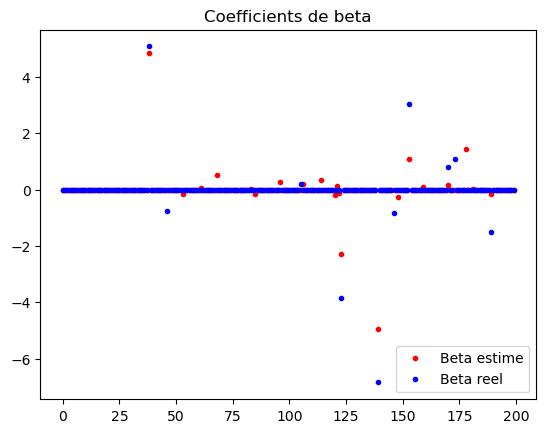

In [9]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


In [10]:
from sklearn.linear_model import LinearRegression

def bic(n,q,mse) :
    return n * np.log10(mse) + np.log10(n)*(q+1)


def forward(X_train, y_train, X_test, y_test):
    n, p = np.shape(X_train)
    selected_variables = []
    remaining_variables = list(range(p))

    current_bic = np.inf
    improved = True

    while improved and remaining_variables:
        improved = False
        best_bic = current_bic
        best_var = None

        for var in remaining_variables:
            # Variables testées = déjà sélectionnées + nouvelle
            candidate_vars = selected_variables + [var]

            X_train_sub = X_train[:, candidate_vars]
            X_test_sub = X_test[:, candidate_vars]

            lr = LinearRegression()
            lr.fit(X_train_sub, y_train)
            Y_pred = lr.predict(X_test_sub)

            mse = mean_squared_error(y_test, Y_pred)
            bic_value = bic(n, len(candidate_vars), mse)

            if bic_value < best_bic:
                best_bic = bic_value
                best_var = var

        # Si on a trouvé une meilleure variable, on la garde
        if best_var is not None:
            selected_variables.append(best_var)
            remaining_variables.remove(best_var)
            current_bic = best_bic
            improved = True

    return selected_variables, current_bic

In [11]:
selected_variables, bic = forward(X_train, y_train, X_test, y_test)
print(selected_variables, bic)

[139, 123, 38, 153, 189, 58, 79, 176, 23, 51, 93, 107, 3, 18, 172, 55, 116] -131.22673217773513


In [12]:
X_train_best = X_train[:, selected_variables]
X_test_best = X_test[:, selected_variables]

lr = LinearRegression()
lr.fit(X_train_best, y_train)
Y_pred = lr.predict(X_test_best)

mse = mean_squared_error(y_test, Y_pred)

print(mse)

0.0032770036414575317


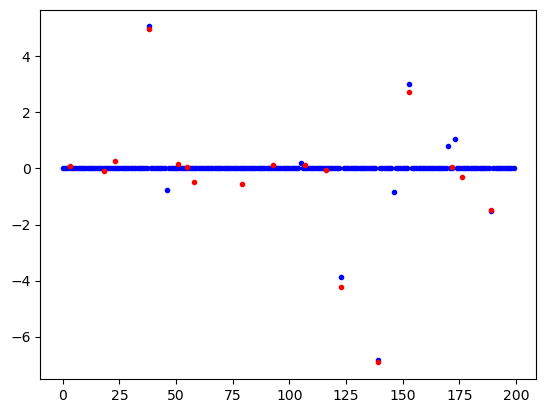

In [19]:
plt.figure()
plt.plot(beta,'b.')
plt.plot(selected_variables,lr.coef_,'r.')
